## Reading in a short story as text sample into Python.

In [1]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20782
THE VERDICT
June 1908

I had always thought Jack Gisburn rather a cheap genius--though a

good fell


### BYTE PAIR ENCODING (BPE)


<div class="alert alert-block alert-success">

We implemented a simple tokenization scheme in the previous sections for illustration
purposes. 

This section covers a more sophisticated tokenization scheme based on a concept
called byte pair encoding (BPE). 

The BPE tokenizer covered in this section was used to train
LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT.</div>

<div class="alert alert-block alert-warning">

Since implementing BPE can be relatively complicated, we will use an existing Python
open-source library called tiktoken (https://github.com/openai/tiktoken). 

This library implements
the BPE algorithm very efficiently based on source code in Rust.
</div>

In [2]:
#! pip3 install tiktoken

In [3]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


<div class="alert alert-block alert-success">
Once installed, we can instantiate the BPE tokenizer from tiktoken as follows:</div>


In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

<div class="alert alert-block alert-success">
The usage of this tokenizer is similar to SimpleTokenizerV2 we implemented previously via
an encode method:</div>



In [5]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


<div class="alert alert-block alert-info">
    
The code above prints the following token IDs:

</div>

<div class="alert alert-block alert-success">
We can then convert the token IDs back into text using the decode method, similar to our
SimpleTokenizerV2 earlier:</div>


In [6]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


<div class="alert alert-block alert-warning">

We can make two noteworthy observations based on the token IDs and decoded text
above. 

First, the <|endoftext|> token is assigned a relatively large token ID, namely,
50256. 

In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3,
and the original model used in ChatGPT, has a total vocabulary size of 50,257, with
<|endoftext|> being assigned the largest token ID.
    


</div>

<div class="alert alert-block alert-warning">

Second, the BPE tokenizer above encodes and decodes unknown words, such as
"someunknownPlace" correctly. 

The BPE tokenizer can handle any unknown word. How does
it achieve this without using <|unk|> tokens?
    


</div>

<div class="alert alert-block alert-warning">

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary
into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words. 

So, thanks to the BPE algorithm, if the tokenizer encounters an
unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or
characters
    


</div>

**Let us take another simple example to illustrate how the BPE tokenizer deals with unknown tokens**

In [7]:
integers = tokenizer.encode("Akwirw ier")
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


### CREATING INPUT-TARGET PAIRS

<div class="alert alert-block alert-success">
In many machine learning tasks, such as classification, the input and output are usually straightforward. For instance, when distinguishing between cats and dogs in images, the images themselves serve as the input, while the classification of each image as either a cat or a dog is the output. Similarly, in a regression problem, such as predicting a house's price based on its area, the area acts as the input and the predicted price is the output. Therefore, establishing input-output or input-target pairs is typically a simple process.<br>
    For large language models we use a specific technique for creating these pairs.Given a text sample, extract input blocks as subsamples that serve as input to the LLM, and the LLM’s prediction task during training is to predict the next word that follows the input block. During training, we mask out all words that are past the target. Note that the text shown in this figure below must undergo tokenization before the LLM can process it;
</div>

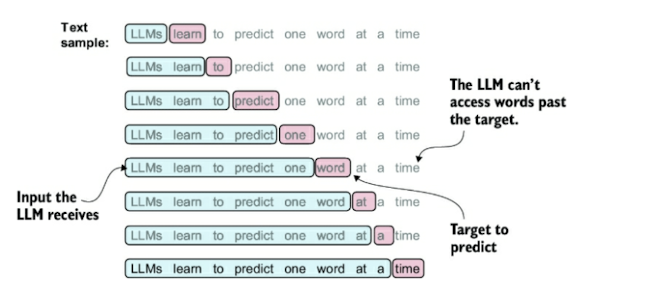

<div class="alert alert-block alert-info">
LLMs cannot access words beyond the target word. There are two key points to keep in mind: First, within a sentence, we divide it into an input and a target, with the target being the next word. Second, in subsequent iterations, the output from the previous iteration becomes the input for the next one. This approach is known as an autoregressive model because the output from one iteration is used as the input for the following iteration.<br>
    In this iteration, the previous output becomes part of the new input, and the next word becomes the output. This is why it's referred to as autoregressive. It's also considered self-supervised or unsupervised learning because we don't label the input and output manually. The sentence structure itself guides the prediction of input and output. Unlike image classification tasks, where we must manually label images as "cat" or "dog," here we don't need to specify labels for input and output. A simple code leverages the sentence structure to create input-target pairs automatically. This approach exemplifies unsupervised learning and is known as autoregression.
</div>

<div class="alert alert-block alert-success">
In this section we implement a data loader that fetches the input-target pairs using a sliding window approach.</div>

<div class="alert alert-block alert-success">
To get started, we will first tokenize the whole The Verdict short story we worked with
earlier using the BPE tokenizer introduced in the previous section:</div>



In [8]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5775


<div class="alert alert-block alert-info">
    
Executing the code above will return 5775, the total number of tokens in the training set,
after applying the BPE tokenizer.

</div>

<div class="alert alert-block alert-success">
Next, we remove the first 50 tokens from the dataset for demonstration purposes as it
results in a slightly more interesting text passage in the next steps:</div>

In [9]:
enc_sample = enc_text[50:]


<div class="alert alert-block alert-success">
One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens
and y contains the targets, which are the inputs shifted by 1: <br>
For example input can be X=[1,2,3,4] , Y= [2,3,4,5] -> then what follows is if input = 1 , output = 2 , if input = 1,2 -> output 3 , if input = 1,2,3 then output is 4 and if input = 1,2,3,4 then output = 5. <br>
    Note the context size here is 4 - hence for one sentence we have 4 inputs and we predict 4 tokens one after the other
</div>

<div class="alert alert-block alert-info">
The context size determines how many tokens are included in the input

</div>



In [10]:
context_size = 4 #length of the input
#The context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens) 
#to predict the next word in the sequence. 
#The input x is the first 4 tokens [1, 2, 3, 4], and the target y is the next 4 tokens [2, 3, 4, 5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [11, 339, 550, 5710]
y:      [339, 550, 5710, 465]


<div class="alert alert-block alert-success">
Processing the inputs along with the targets, which are the inputs shifted by one position,
we can then create the next-word prediction tasks as
follows:</div>

In [11]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[11] ----> 339
[11, 339] ----> 550
[11, 339, 550] ----> 5710
[11, 339, 550, 5710] ----> 465


<div class="alert alert-block alert-info">
Everything left of the arrow (---->) refers to the input an LLM would receive, and the token
ID on the right side of the arrow represents the target token ID that the LLM is supposed to
predict. <br>
    Note the number of prediction task is specified by the context size
</div>

<div class="alert alert-block alert-success">
For illustration purposes, let's repeat the previous code but convert the token IDs into
text:</div>

In [13]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

, ---->  he
, he ---->  had
, he had ---->  dropped
, he had dropped ---->  his


<div class="alert alert-block alert-warning">

We've now created the input-target pairs that we can turn into use for the LLM training in
upcoming chapters.
    
</div>

<div class="alert alert-block alert-warning">

There's only one more task before we can turn the tokens into embeddings:implementing an efficient data loader that
iterates over the input dataset and returns the inputs and targets as PyTorch tensors, which
can be thought of as multidimensional arrays.
    
</div>

<div class="alert alert-block alert-warning">

In particular, we are interested in returning two tensors: an input tensor containing the
text that the LLM sees and a target tensor that includes the targets for the LLM to predict,
    
</div>

### IMPLEMENTING A DATA LOADER

<div class="alert alert-block alert-success">
For the efficient data loader implementation, we will use PyTorch's built-in Dataset and
DataLoader classes. <br>
    We are implementing a data loader that fetches the input output Target pairs using a sliding window approach.
</div>

<div class="alert alert-block alert-success">
<br>
<br>

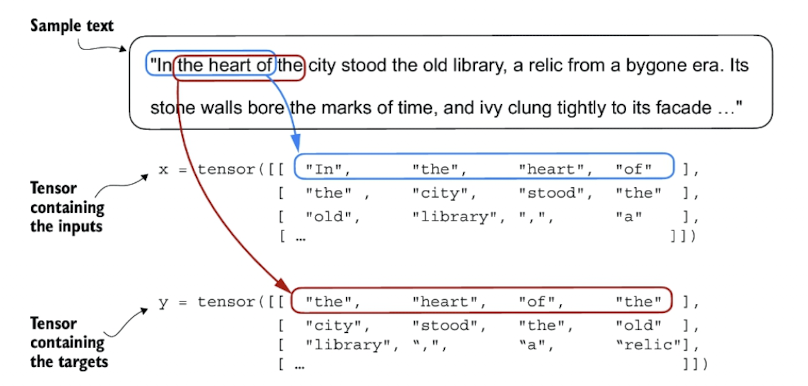

To implement efficient data loaders, we collect the inputs in a tensor, x, where each row represents one input context. A second tensor, y, contains the corresponding prediction targets (next words), which are created by shifting the input by one position. <br>
While the figure shows the tokens in string format for illustration purposes, the code implementation will operate on token IDs directly since the encode method of the BPE tokenizer performs both tokenization and conversion into token IDs as a single step.
</div>

<div class="alert alert-block alert-info">
    
Step 1: Tokenize the entire text
    
Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset
</div>

In [15]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})  #tokenizes the entire text

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):     #Sliding window to chunk txt into overlapping sequence of max length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):    #retruns total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx): #retruns a given input/ouput pair for a given index in the dataset
        return self.input_ids[idx], self.target_ids[idx]

<div class="alert alert-block alert-warning">

The GPTDatasetV1 class in listing 2.5 is based on the PyTorch Dataset class.

It defines how individual rows are fetched from the dataset. 

Each row consists of a number of
token IDs (based on a max_length) assigned to an input_chunk tensor. 

The target_chunk
tensor contains the corresponding targets. 
    
</div>

<div class="alert alert-block alert-success">
The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch
DataLoader:</div>

<div class="alert alert-block alert-info">
    
Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes
during training

Step 4: The number of CPU processes to use for preprocessing
    
</div>

In [16]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

<div class="alert alert-block alert-success">
    
Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4, 

This will develop an intuition of how the GPTDatasetV1 class and the
create_dataloader_v1 function work together: </div>

In [17]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

<div class="alert alert-block alert-info">
    
Convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
    
</div>

In [18]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.4.1
[tensor([[10970, 33310,    35, 18379]]), tensor([[33310,    35, 18379,   198]])]


<div class="alert alert-block alert-warning">

The first_batch variable contains two tensors: the first tensor stores the input token IDs,
and the second tensor stores the target token IDs. 

Since the max_length is set to 4, each of the two tensors contains 4 token IDs. 

Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least
256.
    
</div>

<div class="alert alert-block alert-success">
    
To illustrate the meaning of stride=1, let's fetch another batch from this dataset: </div>

In [19]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[33310,    35, 18379,   198]]), tensor([[   35, 18379,   198, 15749]])]


<div class="alert alert-block alert-warning">

If we compare the first with the second batch, we can see that the second batch's token
IDs are shifted by one position compared to the first batch. 

For example, the second ID in
the first batch's input is 367, which is the first ID of the second batch's input. 

The stride
setting dictates the number of positions the inputs shift across batches, emulating a sliding
window approach

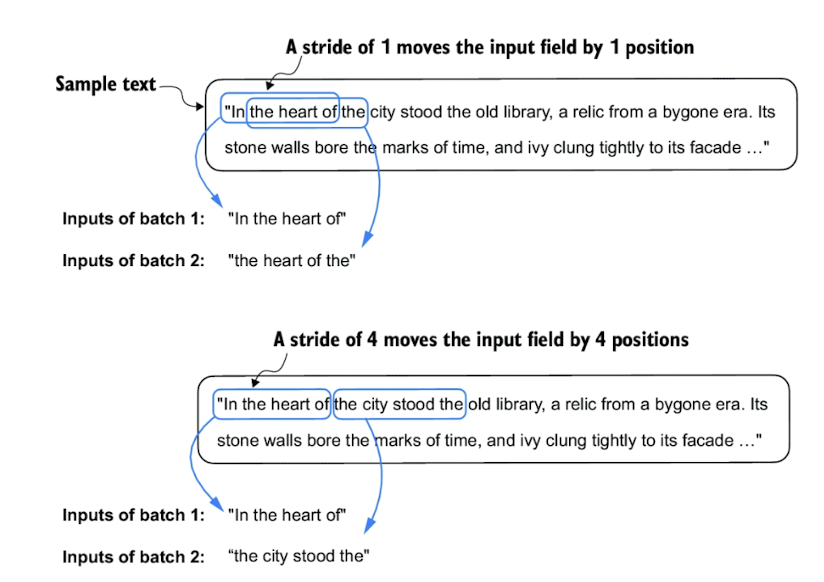

When creating multiple batches from the input dataset, we slide an input window across the text. If the stride is set to 1, we shift the input window by one position when creating the next batch. If we set the stride equal to the input window size, we can prevent overlaps between the batches.
    
</div>

<div class="alert alert-block alert-warning">

Batch sizes of 1, such as we have sampled from the data loader so far, are useful for
illustration purposes. 
                                                                                 
If you have previous experience with deep learning, you may know
that small batch sizes require less memory during training but lead to more noisy model
updates.

Just like in regular deep learning, the batch size is a trade-off and hyperparameter
to experiment with when training LLMs.
    
</div>

<div class="alert alert-block alert-success">
    
Before we move on to the two final sections of this chapter that are focused on creating
the embedding vectors from the token IDs, let's have a brief look at how we can use the
data loader to sample with a batch size greater than 1 <br>
A larger batch size would indicate that weights  will be updated after the samples equal to batch size are executed. Larger batch sizes will result in lesser updates, but would take a longer time and more memory. On the other hander shorter batch size would mean less memory and quicker updates but results will be fluctuating a lot.
</div>

In [21]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[10970, 33310,    35, 18379],
        [  198, 15749, 40417,   198],
        [  198,    40,   550,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  198,   198, 11274,  5891],
        [ 1576,   438,   568,   340]])

Targets:
 tensor([[33310,    35, 18379,   198],
        [15749, 40417,   198,   198],
        [   40,   550,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   198],
        [  198, 11274,  5891,  1576],
        [  438,   568,   340,   373]])


<div class="alert alert-block alert-info">
    
Note that we increase the stride to 4. This is to utilize the data set fully (we don't skip a
single word) but also avoid any overlap between the batches, since more overlap could lead
to increased overfitting.
    
</div>

**CREATE TOKEN EMBEDDINGS**

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])


In [ ]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
print(embedding_layer.weight)


In [ ]:
print(embedding_layer(torch.tensor([3])))


In [ ]:
print(embedding_layer(input_ids))


**POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)**

In [ ]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [ ]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)